## Pneumonia Identification - A Neural Network Model

### Pneumonia infection 
Pneumonia is a common acute respiratory infection that affects the alveoli and distal airways of the lungs. It is associated with high morbidity and is a major health problem with both short term and long term affects. Pneumonia is also widespread occuring in all parts of the globe across all age groups. It is more common in the very young (< 5 years of age) and older adults, particularly amonsgt those who suffer from other health conditions. Nearly one million children per year lose their lives to pneumonia and related causes. The causes of pneumonia have multiple vectors - viral, bacterial, and fungal. Individuals with pneumonia face both respiratory and systemic symptoms. Accurate diagnosis of the infection requires both clinical and radiological (x-ray) methods. Rapid and accurate diagnosis is also crucial to successful treatment, often with a range of antimicrobial therapies.  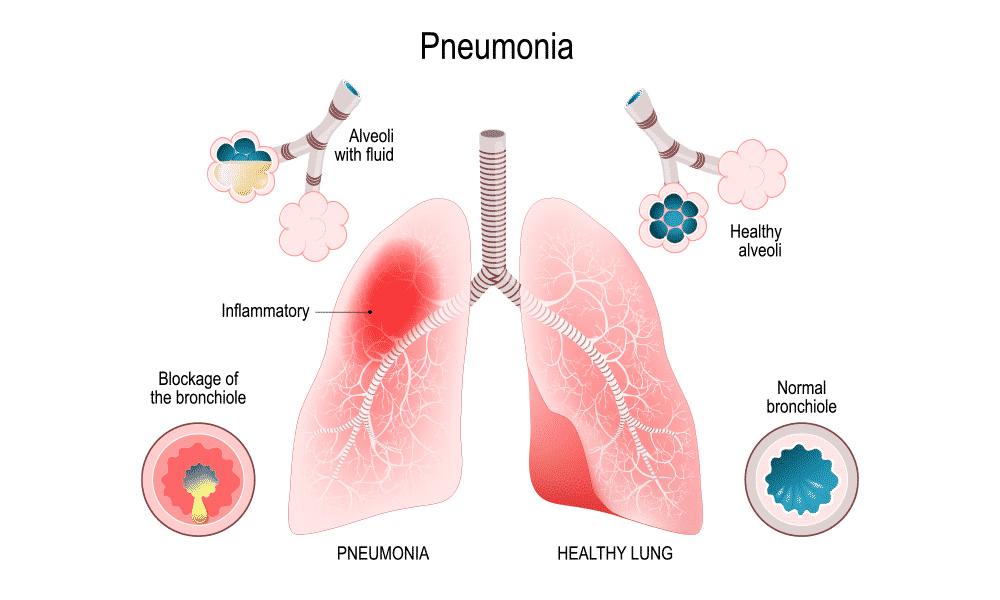

#### Business Case - Intermountain Health Care
Intermountain Health Care (IHC) is a not-for-profit healthcare system based in Utah. Over the past several years they have been working to extend their reach to rural areas. IHC now operates nine hospitals and 23 rural community medical clinics. Despite their reach they face a shortage of medical specialists, particularly radiologists.  

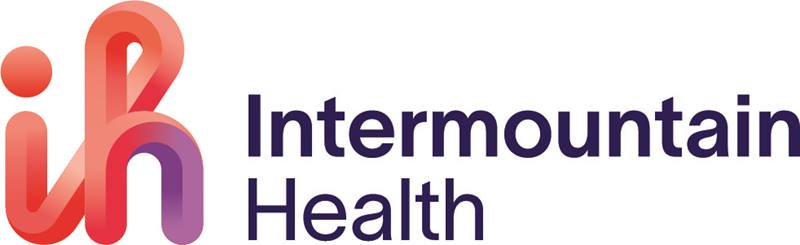

According to the Association of American Medical Colleges there is a growing shortage of trained medical specialist, especially in radiology, psychiatry, and pathology. On average, the number of medical imaging studies increases by a rate of up to five percent per year, but the number of radiology residency positions only increases by two percent. Decreased numbers of radiologists increases the time to make an accurate diagnosis. IHC cannot meet the demand for trained radiologists across their hospital system. The turnaround time for accurate imaging diagnosis, particularly of the lungs for pneumonia and influenza, is increasing which impacts patient care and outcomes. IHC is looking for a data science imaging solution to reduce turnaround times, improve patient outcomes, and to improve efficiency in the radiology diagnostic workflow.

In [6]:
import numpy as np # forlinear algebra
import matplotlib.pyplot as plt #for plotting things
import os, shutil
from PIL import Image
import scipy
from scipy import ndimage

# Keras Libraries
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(123)

### Notebook Data Flow

#### Load Data -->   Process Data for Modeling -->    Baseline Model -->    CNN Model 1 -->   

####        Model 2 with Data Augmentation -->    Model 3 with added layering and padding -->                                    

####        Model 4 with regularization -->    Model 5 tuning of Model 4 --> Model Evaluation  --> Recommendations

#### Dataset Description

The dataset contains a total of 5,856 x-ray images (anterior - posterior) of pediatric patients under the age of 5 years old. The dataset is divided into three folders made up of jpegs: training, validation, and test folders. Each folder contains two classes: Normal and Pneumonia. The images were previously labeled and validated by two expert physicians. To further reduce error a third expert validated their work. The data is available from Kaggle at https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

## Load Data 

In [7]:
train = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/train', labels = 'inferred', 
                                                            class_names = ['NORMAL', 'PNEUMONIA'])

Found 5216 files belonging to 2 classes.


In [8]:
test = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/test', labels = 'inferred',
                                                          class_names = ['NORMAL', 'PNEUMONIA'])

Found 624 files belonging to 2 classes.


In [9]:
val = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/val', labels = 'inferred',
                                                         class_names = ['NORMAL', 'PNEUMONIA'])

Found 16 files belonging to 2 classes.


Pediatric Lung Image - NORMAL


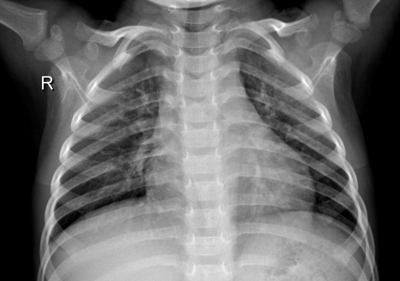

Pediatric Lung Image - PNEUMONIA (viral origins)


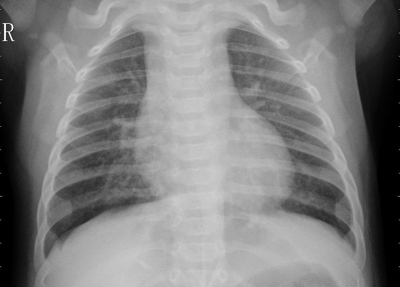

Pediatric Lung Image - PNEUMONIA (bacterial origins)


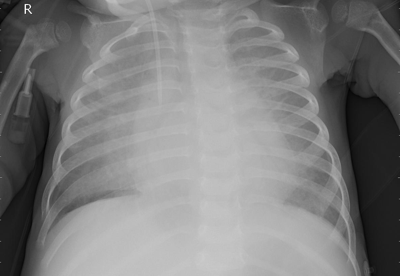

<Figure size 432x288 with 0 Axes>

In [10]:
#Display normal lung image

print('Pediatric Lung Image - NORMAL')

norm_img = Image.open('chest_xray/train/NORMAL/IM-0125-0001.jpeg')
norm_img.thumbnail((400, 400))
display(norm_img)
plt.savefig("normal_xray.png");

# Display pneumonia image with viral origins

print('Pediatric Lung Image - PNEUMONIA (viral origins)')

p_img = Image.open('chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg')
p_img.thumbnail((400, 400))
display(p_img)
plt.savefig("viral_xray.png");

# Display pneumonia image with bacterial origins

print('Pediatric Lung Image - PNEUMONIA (bacterial origins)')

p_img = Image.open('chest_xray/train/PNEUMONIA/person1004_bacteria_2935.jpeg')
p_img.thumbnail((400, 400))
display(p_img)
plt.savefig("bacteria_xray.png");


## Process the datasets for modeling

In [11]:
# Identify shape of each dataset
print('Shape and Datatype of Train dataset:', train)
print()
print('Shape and Datatype of Val dataset:', val)
print()
print('Shape and Datatype of Test dataset:', test)

Shape and Datatype of Train dataset: <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

Shape and Datatype of Val dataset: <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

Shape and Datatype of Test dataset: <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>


In [12]:
#identify file path
train_folder = 'chest_xray/train'
val_folder = 'chest_xray/val'
test_folder = 'chest_xray/test'

In [13]:
# get all the data in the directory, and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), batch_size = 624) 

# get all the data in the directory, and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(64, 64), batch_size = 16)

# get all the data in the directory, and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(64, 64), batch_size = 5216)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [14]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [15]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [16]:
#reshape for deep learning
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 12288)
(624, 12288)
(16, 12288)


In [17]:
#check labels
train_labels[:10]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [18]:
#reshape labels
train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

In [19]:
# check data shapes
train_y.shape

(5216, 1)

In [20]:
test_y.shape

(624, 1)

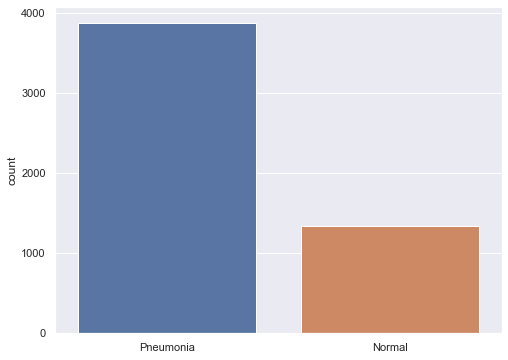

In [168]:
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

show_class = []
for i in train_y:
    if(i == 0):
        show_class.append("Pneumonia")
    else:
        show_class.append("Normal")
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale=2)
sns.set_style('darkgrid')
sns.countplot(show_class)
plt.savefig("class_imbalance_train.png");  

## 1. Build a baseline model

Build a simple baseline model using densely connected layers. 

In [23]:
# Neural network model with two hidden layers
baseline_model = Sequential()

#Input
baseline_model.add(Dense(16, activation='relu', input_shape=(12288,))) 
baseline_model.add(Dense(7, activation='relu'))
baseline_model.add(Dense(5, activation='relu'))
# Binary output
baseline_model.add(Dense(1, activation='sigmoid'))

In [24]:
#compile and train the model

baseline_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

base_history = baseline_model.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_split = 0.2)

Epoch 1/20
131/131 [==============================] - 0s 2ms/step - loss: 0.6683 - accuracy: 0.7289 - val_loss: 0.6289 - val_accuracy: 0.7759
Epoch 2/20
131/131 [==============================] - 0s 1ms/step - loss: 0.6247 - accuracy: 0.7347 - val_loss: 0.5933 - val_accuracy: 0.7759
Epoch 3/20
131/131 [==============================] - 0s 2ms/step - loss: 0.6040 - accuracy: 0.7347 - val_loss: 0.5729 - val_accuracy: 0.7759
Epoch 4/20
131/131 [==============================] - 0s 2ms/step - loss: 0.5930 - accuracy: 0.7347 - val_loss: 0.5605 - val_accuracy: 0.7759
Epoch 5/20
131/131 [==============================] - 0s 2ms/step - loss: 0.5867 - accuracy: 0.7347 - val_loss: 0.5527 - val_accuracy: 0.7759
Epoch 6/20
131/131 [==============================] - 0s 1ms/step - loss: 0.5833 - accuracy: 0.7347 - val_loss: 0.5478 - val_accuracy: 0.7759
Epoch 7/20
131/131 [==============================] - 0s 1ms/step - loss: 0.5813 - accuracy: 0.7347 - val_loss: 0.5447 - val_accuracy: 0.7759
Epoch 

#### Model Evaluation



In [25]:
# Baseline training results
base_results_train = baseline_model.evaluate(train_img, train_y)

163/163 [==============================] - 0s 985us/step - loss: 0.5702 - accuracy: 0.7429


In [26]:
base_results_val = baseline_model.evaluate(val_img, val_y)

1/1 [==============================] - 0s 797us/step - loss: 0.8166 - accuracy: 0.5000


In [27]:
test_results_val = baseline_model.evaluate(test_img, test_y)

20/20 [==============================] - 0s 847us/step - loss: 0.6898 - accuracy: 0.6250


In [28]:
#Print results for train and test
print("Baseline Results from Training Data:", base_results_train)
print()
print("Baseline Results from Validation Data:", base_results_val)



Baseline Results from Training Data: [0.5702065825462341, 0.7429064512252808]

Baseline Results from Validation Data: [0.8165658116340637, 0.5]


In [29]:
# Plot train and test loss and accuracy
def visualize_training_results(results):
    sns.set(font_scale=1)
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

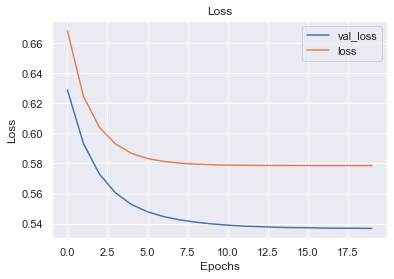

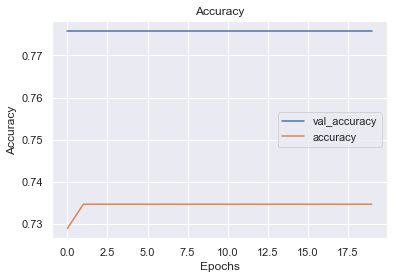

In [30]:
visualize_training_results(base_history)

#### Baseline Model summary 
The baseline model was generated with a densely layered neural network with two hidden layers. The training results scored 95.5% accuracy rate but the test score is at 77.9%. This model appears overfit and too sensitive to noise in the training dataset. 

## CNN Model - Model 1

Include convolution layers for image processaing and Dense layering - 2 hidden layers.

In [31]:
#Instantiate a CNN model

model_1 = Sequential()

# Add convolution layer

model_1.add(Conv2D(32, (3, 3), activation = 'relu',
                   input_shape = (64, 64, 3)))


# Add another convolution layer

model_1.add(Conv2D(64, (3, 3), activation='relu'))


# Flatten the model

model_1.add(Flatten())

# Add dense layers, two hidden

model_1.add(Dense(64, activation = 'relu'))
model_1.add(Dense(7, activation = 'relu'))
model_1.add(Dense(5, activation = 'relu'))

# Add the output layer for binary - normal or pneumonia

model_1.add(Dense(1))
model_1.add(Activation('sigmoid'))

# Compile the model with binary cross entropy as loss and rmsprop for optimizer

model_1.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [32]:
# Examine the built model
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 230400)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                14745664  
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 455       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [33]:
# Fit the model
history_1 = model_1.fit(train_images, 
                        train_y, 
                        epochs=20, 
                        validation_split = 0.2) 
                                

Epoch 1/20
131/131 [==============================] - 26s 202ms/step - loss: 0.9830 - accuracy: 0.7258 - val_loss: 0.4099 - val_accuracy: 0.7759
Epoch 2/20
131/131 [==============================] - 27s 209ms/step - loss: 0.3675 - accuracy: 0.7924 - val_loss: 0.2841 - val_accuracy: 0.9109
Epoch 3/20
131/131 [==============================] - 27s 208ms/step - loss: 0.2709 - accuracy: 0.9274 - val_loss: 0.1982 - val_accuracy: 0.9646
Epoch 4/20
131/131 [==============================] - 27s 205ms/step - loss: 0.2370 - accuracy: 0.9398 - val_loss: 0.1730 - val_accuracy: 0.9674
Epoch 5/20
131/131 [==============================] - 27s 207ms/step - loss: 0.2064 - accuracy: 0.9468 - val_loss: 0.1680 - val_accuracy: 0.9521
Epoch 6/20
131/131 [==============================] - 26s 200ms/step - loss: 0.1959 - accuracy: 0.9571 - val_loss: 0.1436 - val_accuracy: 0.9674
Epoch 7/20
131/131 [==============================] - 26s 198ms/step - loss: 0.1465 - accuracy: 0.9626 - val_loss: 0.2287 - val_ac

#### Model evaluation

In [34]:
results_1_train = model_1.evaluate(train_images, train_y)

163/163 [==============================] - 5s 30ms/step - loss: 0.0468 - accuracy: 0.9904


In [35]:
results_1_test = model_1.evaluate(test_images, test_y)

20/20 [==============================] - 1s 32ms/step - loss: 3.8646 - accuracy: 0.6923


In [36]:
#Print results for Model 1 train and test
print("Model 1 Results from Training Data:", results_1_train)
print()
print("Model 1 Results from Test Data:", results_1_test)



Model 1 Results from Training Data: [0.04681295156478882, 0.9904140830039978]

Model 1 Results from Test Data: [3.864631414413452, 0.692307710647583]


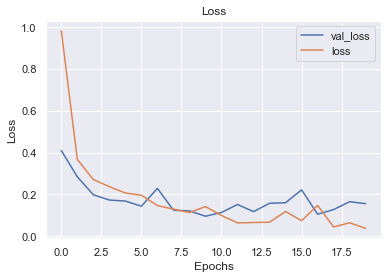

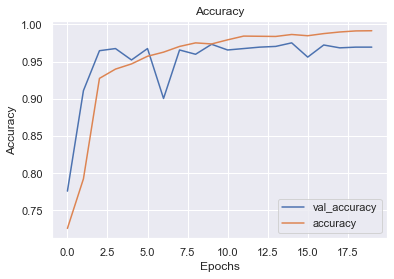

In [37]:
# Plot accuracy and loss
visualize_training_results(history_1)

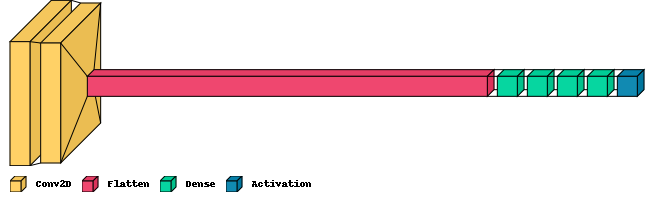

In [426]:
# Visualize the model build with Keras
import visualkeras
from PIL import ImageFont
#font = ImageFont.truetype("arial.ttf")

visualkeras.layered_view(model_1, legend=True, scale_xy = 2, to_file = 'visual_model_1.png') 


#### Model Evaluation

Convolutional layers were added to a densely connected network, the optimizer was also changed to 'rmsprop' for adaptive learning rate rather than 'sgd' at a constant rate. The training dataset accuracy approaches 99% but the test accuracy rate comes in at 69% leading to a severely overfit model. Maxpooling and regularization techniques should be used in future iterations. 

## Model 2 - Data Augmentation 
Add data augmentation to account for imbalanced classes. Include Maxpooling after Convolution Layers.

In [38]:
# Augment the training and test data to account for class imbalance
train_datagen = ImageDataGenerator(rescale=1./255, 
                             rotation_range=20, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             shear_range=0.2, 
                             zoom_range=0.1, 
                             horizontal_flip=True, 
                             fill_mode = 'nearest',
                             #split for a validation set as equal to the length of the test set
                             validation_split = 0.12)

test_datagen = ImageDataGenerator(rescale = 1./255)

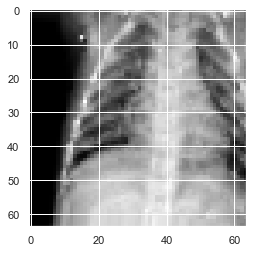

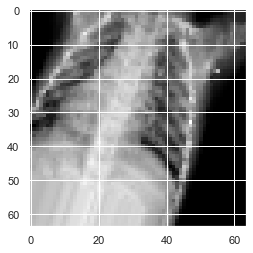

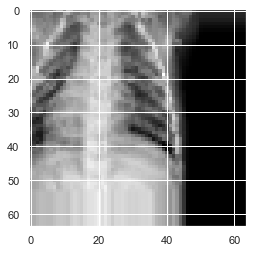

In [39]:
# View an augmented image

# Load image
img = load_img('chest_xray/train/NORMAL/IM-0125-0001.jpeg', target_size=(64, 64))

# Reshape
reshape_img = img_to_array(img) 
reshape_img = reshape_img.reshape((1,) + reshape_img.shape) 

# Run image through augmented image generator

i=0
for batch in train_datagen.flow(reshape_img, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
        
plt.show()

In [40]:
# Set image size for shaping
img_size = 150

# Train generator - training subset
train_generator = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(img_size, img_size), 
        batch_size = 32, 
        class_mode='binary', 
        subset = "training")

# Validation Generator - validation subset
val_generator = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(img_size, img_size),
        batch_size = 32,
        class_mode='binary', 
        subset = "validation")

# Test Generator 
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(img_size, img_size), 
        batch_size = 624,
        class_mode='binary') 


Found 4591 images belonging to 2 classes.
Found 625 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [41]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [42]:
train_labels.shape

(32,)

In [43]:
train_images.shape

(32, 150, 150, 3)

In [44]:
test_images.shape

(624, 150, 150, 3)

In [45]:
#Instantiate a CNN model

model_2 = Sequential()

# Add convolution layer

model_2.add(Conv2D(32, (3, 3), activation = 'relu',
                   input_shape= (img_size, img_size, 3)))

# Add a maxpooling layer

model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Add another convolution layer

model_2.add(Conv2D(64, (4, 4), activation='relu'))

# Add another maxpooling layer

model_2.add(MaxPooling2D((2, 2)))

# Flatten the model

model_2.add(Flatten())

# Add dense layers

model_2.add(Dense(32, activation = 'relu'))

# Add the output layer for binary - normal or pneumonia

model_2.add(Dense(1))
model_2.add(Activation('sigmoid'))

# Compile the model with binary cross entropy as loss and rmsprop for optimizer

model_2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [46]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 78400)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2508832   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [47]:
history_2 = model_2.fit(train_generator,
                      epochs=20, 
                      validation_data = val_generator,
                      verbose = 1)

Epoch 1/20
144/144 [==============================] - 102s 708ms/step - loss: 0.5638 - accuracy: 0.7499 - val_loss: 0.5149 - val_accuracy: 0.7520
Epoch 2/20
144/144 [==============================] - 102s 708ms/step - loss: 0.3833 - accuracy: 0.8244 - val_loss: 0.4422 - val_accuracy: 0.8048
Epoch 3/20
144/144 [==============================] - 105s 730ms/step - loss: 0.3304 - accuracy: 0.8536 - val_loss: 0.4099 - val_accuracy: 0.8192
Epoch 4/20
144/144 [==============================] - 107s 745ms/step - loss: 0.3049 - accuracy: 0.8667 - val_loss: 0.3498 - val_accuracy: 0.8192
Epoch 5/20
144/144 [==============================] - 114s 788ms/step - loss: 0.2954 - accuracy: 0.8752 - val_loss: 0.4179 - val_accuracy: 0.8080
Epoch 6/20
144/144 [==============================] - 112s 781ms/step - loss: 0.2684 - accuracy: 0.8924 - val_loss: 0.4031 - val_accuracy: 0.7984
Epoch 7/20
144/144 [==============================] - 114s 790ms/step - loss: 0.2465 - accuracy: 0.8954 - val_loss: 0.2880 -

#### Evaluate model

In [48]:
results_2_train = model_2.evaluate(train_images, train_labels)

1/1 [==============================] - 0s 1ms/step - loss: 0.1411 - accuracy: 0.9688


In [49]:
results_2_test = model_2.evaluate(test_images, test_labels)

20/20 [==============================] - 1s 66ms/step - loss: 0.3806 - accuracy: 0.8413


In [50]:
results_2_val = model_2.evaluate(val_images, val_labels)

1/1 [==============================] - 0s 803us/step - loss: 0.3232 - accuracy: 0.9375


In [51]:
#Print results for Model 1 train and test
print("Model 2 Results from Training Data:", results_2_train)
print()
print("Model 2 Results from Test Data:", results_2_test)


Model 2 Results from Training Data: [0.14105980098247528, 0.96875]

Model 2 Results from Test Data: [0.3806001842021942, 0.8413461446762085]


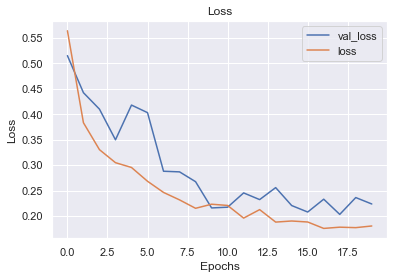

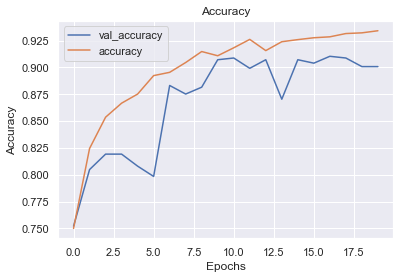

In [52]:
# Plot accuracy and loss
visualize_training_results(history_2)

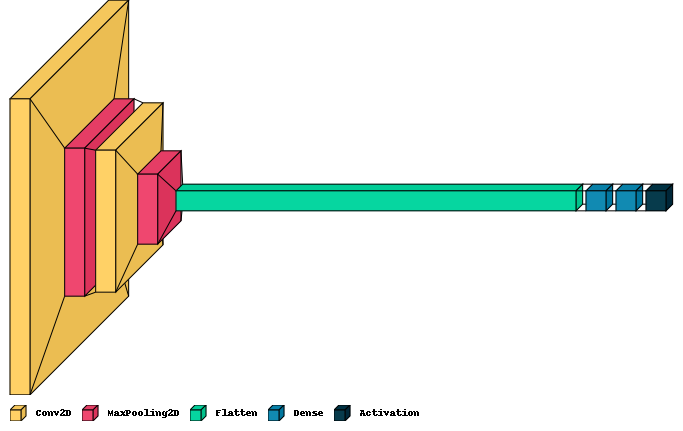

In [427]:
# Visualize the model build with Keras
import visualkeras
from PIL import ImageFont
#font = ImageFont.truetype("arial.ttf")

visualkeras.layered_view(model_2, legend=True, scale_xy = 2, to_file = 'visual_model_2.png') 


#### Model 2 summary 
Data augmentation was added to the datasets to address imbalances. Maxpooling was also introduced to consolidate features learned from the convolutional layers. Dense layers were reduced to eliminate hidden layers. The model's training accuracy approaches the baseline model at 96% and test accuracy improved to 84%. The gap between training and test accuracy is reduced overall from baseline but the model remains overfitted.

## Model 3 
Added Convolution and MaxPooling layers, Adam optimizer, included Padding and Stride adjustment

In [53]:
#Instantiate a CNN model

model_3 = Sequential()

# Add convolution layer

model_3.add(Conv2D(32, (3, 3), padding = 'same', strides = 1, activation = 'relu',
                   input_shape= (img_size, img_size, 3)))

# Add a maxpooling layer

model_3.add(MaxPooling2D(pool_size=(2, 2), strides = 2, padding = 'same'))


model_3.add(Conv2D(64, (3, 3), padding = 'same', strides = 1, activation='relu'))
model_3.add(MaxPooling2D((2, 2), padding = 'same', strides = 1))

model_3.add(Conv2D(128, (3, 3), padding = 'same', strides = 2, activation='relu'))
model_3.add(MaxPooling2D((2, 2), padding = 'same', strides = 1))

model_3.add(Conv2D(256, (3, 3), padding = 'same', strides = 2, activation='relu'))
model_3.add(MaxPooling2D((2, 2), padding = 'same', strides = 1))

# Flatten the model

model_3.add(Flatten())

# Add dense layers

model_3.add(Dense(64, activation = 'relu'))
model_3.add(Dense(1, activation = 'sigmoid'))

# Compile the model with binary cross entropy as loss and 'adam' for optimizer

model_3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [54]:
model_3.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 38, 38, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 19, 19, 256)      

In [55]:
history_3 = model_3.fit(train_generator,  
                      epochs=20, 
                      validation_data=val_generator,
                      verbose = 1) 
                      

Epoch 1/20
144/144 [==============================] - 121s 840ms/step - loss: 0.4779 - accuracy: 0.7824 - val_loss: 0.3456 - val_accuracy: 0.8240
Epoch 2/20
144/144 [==============================] - 121s 840ms/step - loss: 0.2952 - accuracy: 0.8711 - val_loss: 0.3798 - val_accuracy: 0.8128
Epoch 3/20
144/144 [==============================] - 120s 837ms/step - loss: 0.2424 - accuracy: 0.8996 - val_loss: 0.2983 - val_accuracy: 0.8720
Epoch 4/20
144/144 [==============================] - 121s 839ms/step - loss: 0.2411 - accuracy: 0.8950 - val_loss: 0.3891 - val_accuracy: 0.8352
Epoch 5/20
144/144 [==============================] - 120s 836ms/step - loss: 0.2089 - accuracy: 0.9129 - val_loss: 0.2588 - val_accuracy: 0.8736
Epoch 6/20
144/144 [==============================] - 120s 836ms/step - loss: 0.2075 - accuracy: 0.9137 - val_loss: 0.2759 - val_accuracy: 0.8688
Epoch 7/20
144/144 [==============================] - 120s 835ms/step - loss: 0.1918 - accuracy: 0.9242 - val_loss: 0.3311 -

#### Evaluate model

In [56]:
results_3_train = model_3.evaluate(train_images, train_labels)

1/1 [==============================] - 0s 1ms/step - loss: 0.0664 - accuracy: 0.9688


In [57]:
results_3_test = model_3.evaluate(test_images, test_labels)

20/20 [==============================] - 3s 125ms/step - loss: 0.4134 - accuracy: 0.8365


In [58]:
results_3_val = model_3.evaluate(val_images, val_labels)

1/1 [==============================] - 0s 808us/step - loss: 0.2551 - accuracy: 0.9375


In [59]:
#Print results for Model 1 train and test
print("Model 3 Results from Training Data:", results_3_train)
print()
print("Model 3 Results from Test Data:", results_3_test)


Model 3 Results from Training Data: [0.0663568452000618, 0.96875]

Model 3 Results from Test Data: [0.4134195148944855, 0.8365384340286255]


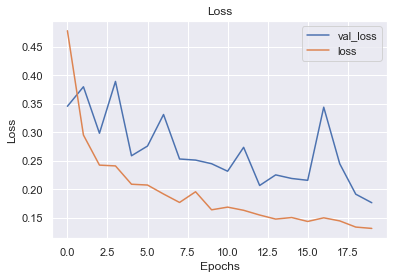

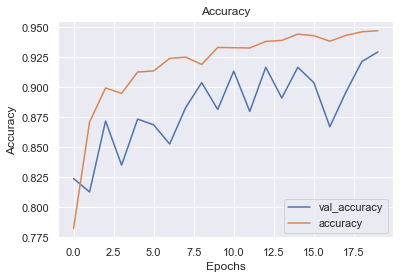

In [60]:
# Plot accuracy and loss
visualize_training_results(history_3)

In [61]:
# Generate predictions

predictions = model_3.predict(test_images)

predictions[:10]

array([[0.8120265 ],
       [0.99713814],
       [0.9969243 ],
       [0.99996483],
       [0.99396914],
       [0.8391377 ],
       [0.06833202],
       [0.9978201 ],
       [0.9926419 ],
       [0.99221575]], dtype=float32)

In [62]:
y_hat_test = np.round(predictions)

In [63]:
y_hat_test[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [65]:
# Display confusion matrix

print('Confusion Matrix')
print(confusion_matrix(test_labels, y_hat_test))

Confusion Matrix
[[138  96]
 [  6 384]]


In [67]:
#print classification_report

print(classification_report(test_labels, y_hat_test, target_names = ['Normal (Class 0)', 'Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.96      0.59      0.73       234
Pneumonia (Class 1)       0.80      0.98      0.88       390

           accuracy                           0.84       624
          macro avg       0.88      0.79      0.81       624
       weighted avg       0.86      0.84      0.83       624



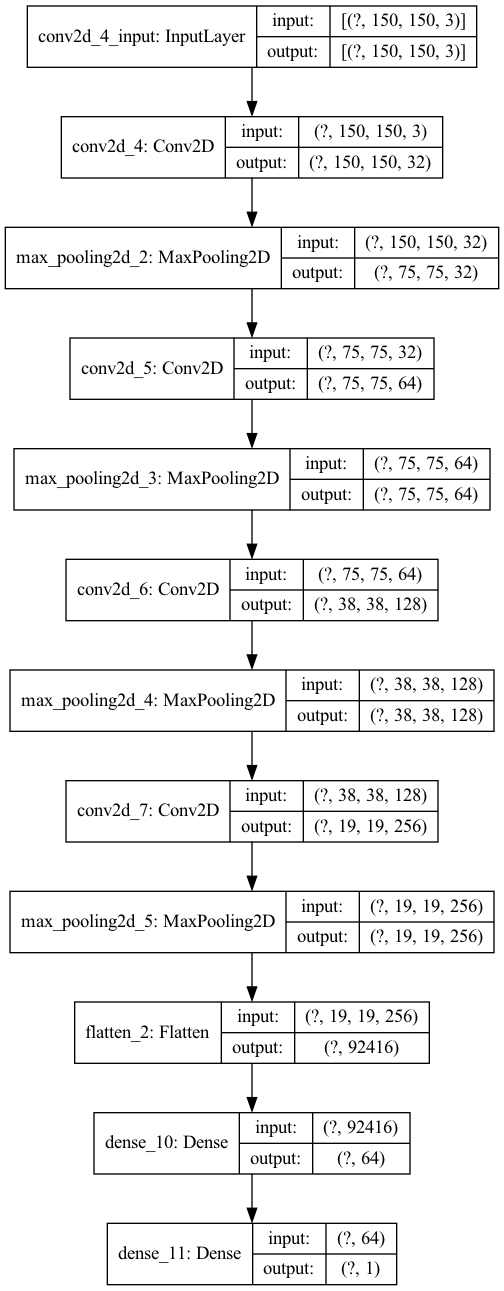

In [69]:
# Visualize the model architecture flow
import graphviz
import pydot
from keras.utils.vis_utils import plot_model
plot_model(model_3, to_file = 'model_3_architecture.png', show_shapes = True, show_layer_names = True)

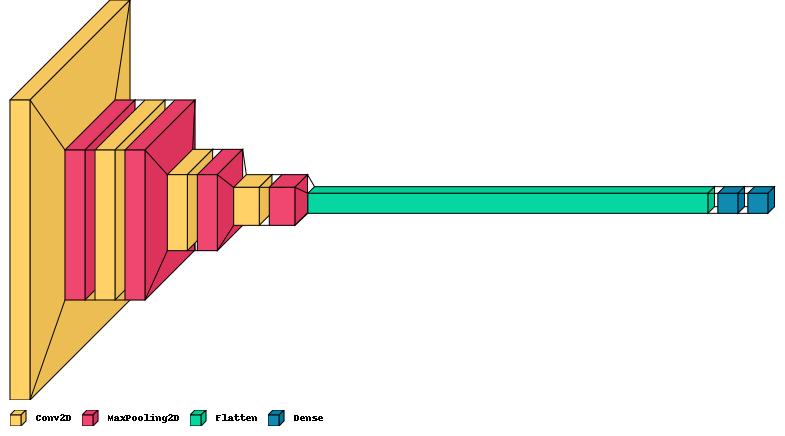

In [74]:
# Visualize the model build with Keras
import visualkeras
from PIL import ImageFont
#font = ImageFont.truetype("arial.ttf")

visualkeras.layered_view(model_3, legend=True, scale_xy = 2, to_file = 'visual_model_5.png') 


#### Model 3 Summary 

Padding was added to the model to extend the area available for analysis to the convolutional layers. Increased strides were also introduced to allow for some compression of the resulting feature maps in each layer. The optimizer was also changed to 'adam' to allow for increased adaptive learning rates to be applied to each parameter. Very little changes in accuracy were realized from the previous model: model_2. The generated classification report provides deeper insight into recall and precision. Recall rate for pneumonia was quite strong at 98% suggesting the model is capable of catching most cases of pneumonia in test data, but at the expense of generating numerous false positive cases. Based on recall nearly half of the cases that were predicted for pneumonia do not actually have pneumonia. The goal of the next model iterations should be to maintain high recall rate for diagnosing pneumonia while attempting to reduce false positive cases.

## Model 4 - Added layering and regularization (L2 and dropouts)


In [85]:
#Instantiate a CNN model, 
# L2 Regularize on the model steps with greatest amount of parameters. 

img_size = 150

model_4 = Sequential()

# Add convolution layer with alternating strides

model_4.add(Conv2D(8, (3, 3), 
                   padding = 'same', strides = 1, activation = 'relu',
                   input_shape= (img_size, img_size, 3)))

# Add a maxpooling layer

model_4.add(MaxPooling2D(pool_size=(2, 2), strides = 1))

# Add dropout at 10%
model_4.add(Dropout(0.1))


#Layer 2

model_4.add(Conv2D(16, (3, 3), padding = 'same', strides = 1,  
                   activation='relu'))
model_4.add(MaxPooling2D((2, 2), strides = 2))
model_4.add(Dropout(0.1))

#Layer 3

model_4.add(Conv2D(32, (3, 3), padding = 'same', strides = 1,  
                   activation='relu'))
model_4.add(MaxPooling2D((2, 2), strides = 2))
model_4.add(Dropout(0.1))


#Layer 4

model_4.add(Conv2D(64, (3, 3), padding = 'same', strides = 1, 
                   kernel_regularizer =tf.keras.regularizers.l2( l=0.005), 
                   activation='relu'))
model_4.add(MaxPooling2D((2, 2), strides = 2))
model_4.add(Dropout(0.1))


#Layer 5
model_4.add(Conv2D(128, (3, 3), padding = 'same', strides = 1, 
                   kernel_regularizer =tf.keras.regularizers.l2( l=0.005), 
                   activation='relu'))
model_4.add(MaxPooling2D((2, 2), strides = 2))
model_4.add(Dropout(0.1))

# Flatten the model

model_4.add(Flatten())

# Add dense layers, two hidden

model_4.add(Dense(128,  kernel_regularizer =tf.keras.regularizers.l2(l=0.005), 
                  activation = 'relu'))
model_4.add(Dropout(0.1))

# Add the output layer for binary - normal or pneumonia

model_4.add(Dense(1))
model_4.add(Activation('sigmoid'))

# Compile the model with binary cross entropy as loss and 'adam' for optimizer

model_4.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [86]:
model_4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 150, 150, 8)       224       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 149, 149, 8)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 149, 149, 8)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 149, 149, 16)      1168      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 74, 74, 32)       

In [87]:
history_4 = model_4.fit(train_generator, 
                       epochs = 30, 
                       validation_data=val_generator)

Epoch 1/30
144/144 [==============================] - 103s 713ms/step - loss: 0.9562 - accuracy: 0.7406 - val_loss: 0.6092 - val_accuracy: 0.7440
Epoch 2/30
144/144 [==============================] - 102s 710ms/step - loss: 0.5599 - accuracy: 0.7406 - val_loss: 0.5083 - val_accuracy: 0.7664
Epoch 3/30
144/144 [==============================] - 102s 706ms/step - loss: 0.4796 - accuracy: 0.7955 - val_loss: 0.5019 - val_accuracy: 0.7728
Epoch 4/30
144/144 [==============================] - 102s 705ms/step - loss: 0.4234 - accuracy: 0.8303 - val_loss: 0.4507 - val_accuracy: 0.8032
Epoch 5/30
144/144 [==============================] - 102s 707ms/step - loss: 0.3840 - accuracy: 0.8432 - val_loss: 0.4082 - val_accuracy: 0.8208
Epoch 6/30
144/144 [==============================] - 102s 705ms/step - loss: 0.3539 - accuracy: 0.8595 - val_loss: 0.3786 - val_accuracy: 0.8304
Epoch 7/30
144/144 [==============================] - 101s 704ms/step - loss: 0.3279 - accuracy: 0.8721 - val_loss: 0.3586 -

#### Evaluate Model 4

In [88]:
# Results for train, val and test
results_4_train = model_4.evaluate(train_images, train_labels)

1/1 [==============================] - 0s 813us/step - loss: 0.3290 - accuracy: 0.8750


In [89]:
results_4_test = model_4.evaluate(test_images, test_labels)

20/20 [==============================] - 2s 81ms/step - loss: 0.9442 - accuracy: 0.7115


In [90]:
results_4_val = model_4.evaluate(val_images, val_labels)

1/1 [==============================] - 0s 811us/step - loss: 0.2914 - accuracy: 0.9062


In [91]:
#Print results for Model 4 train and test
print("Model 4 Results from Training Data:", results_4_train)
print()
print("Model 4 Results from Test Data:", results_4_test)


Model 4 Results from Training Data: [0.3289510905742645, 0.875]

Model 4 Results from Test Data: [0.9441511631011963, 0.7115384340286255]


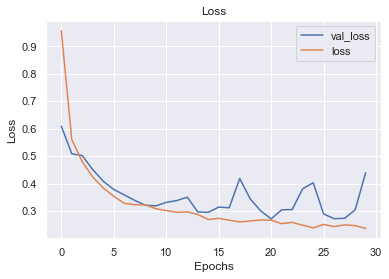

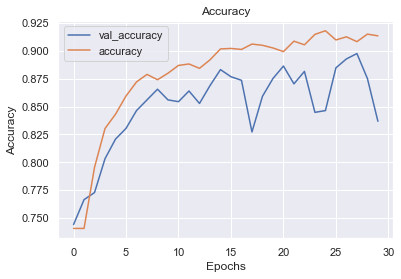

In [92]:
# Plot Loss and Accuracy
visualize_training_results(history_4)

In [100]:
# Generate predictions
predictions = model_4.predict(test_images)
y_pred = np.round(predictions)
y_pred[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [101]:
cm_4 = confusion_matrix(test_labels, y_pred)
cm_4

array([[ 56, 178],
       [  2, 388]])

In [102]:
import itertools

In [103]:
# Create a function to plot confusion matrix. Thanks to deep lizard resources.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [104]:
#Confirm indices of each class
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Confusion matrix, without normalization
[[ 56 178]
 [  2 388]]


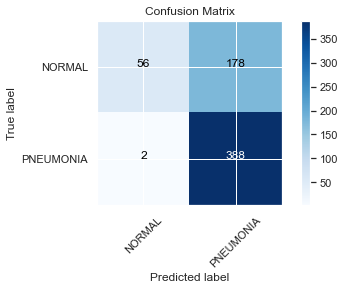

In [105]:
cm_plot_labels = ['NORMAL','PNEUMONIA']
plot_confusion_matrix(cm=cm_4, classes=cm_plot_labels, title='Confusion Matrix')

In [106]:
print(classification_report(test_labels, y_pred, target_names = ['Normal (Class 0)', 'Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.97      0.24      0.38       234
Pneumonia (Class 1)       0.69      0.99      0.81       390

           accuracy                           0.71       624
          macro avg       0.83      0.62      0.60       624
       weighted avg       0.79      0.71      0.65       624



#### model 4 summary

Model 4 improved pneumonia detection recall rate but in doing so predicted most of the images as pneumonia generating far too many false positives. This model is struggling to identify normal cases of lungs. Model 5 should include more regularization by inlduing increased dropout and L2 regularization along with callbacks to stop the training if no loss is calculated to prevent overfitting. 

### Model 5  - Regularization of Model_4
Increase dropout amount, increase regularization to 0.01, reduce learning rate and introduce decay rate. Add another layer for model complexity. Include callback to terminate training if no loss detected after 4 or 5 epochs.

In [349]:
#Instantiate a CNN model
model_5 = Sequential()

# Apply 4 layers of Convolution with Maxpooling with regularization: Dropouts, L2, Normalization

#Layer1
model_5.add(Conv2D(8, (7, 7), 
                   padding = 'same', strides = 1, activation = 'relu',
                   kernel_regularizer =tf.keras.regularizers.l2(l=0.01),
                   input_shape= (img_size, img_size, 3)))
model_5.add(MaxPooling2D(pool_size=(2, 2), strides = 2))
model_5.add(Dropout(0.2))


#Layer2
model_5.add(Conv2D(16, (5, 5), 
                   kernel_regularizer =tf.keras.regularizers.l2(l=0.01),
                   padding = 'same', strides = 1, activation='relu'))
model_5.add(MaxPooling2D((2, 2), strides = 2))
model_5.add(Dropout(0.2))

#Layer3
model_5.add(Conv2D(32, (3, 3), kernel_regularizer =tf.keras.regularizers.l2(l=0.01),
                   padding = 'same', strides = 1, activation='relu'))
model_5.add(MaxPooling2D((2, 2), strides = 2))
model_5.add(Dropout(0.2))

#Layer4
model_5.add(Conv2D(64, (3, 3), 
                   kernel_regularizer =tf.keras.regularizers.l2(l=0.01),
                   padding = 'same', strides = 1, activation='relu'))
model_5.add(MaxPooling2D((2, 2), strides = 2))
model_5.add(Dropout(0.2))

#Layer5
model_5.add(Conv2D(128, (3, 3), 
                   kernel_regularizer =tf.keras.regularizers.l2(l=0.01),
                   padding = 'same', strides = 1, activation='relu'))
model_5.add(MaxPooling2D((2, 2), strides = 2))
model_5.add(Dropout(0.2))

# Flatten the model
model_5.add(Flatten())

# Add dense layers
model_5.add(Dense(128,  
                  kernel_regularizer =tf.keras.regularizers.l2(l=0.01), 
                  activation = 'relu'))
model_5.add(Dropout(0.2))

# Add the output layer for binary - normal or pneumonia

model_5.add(Dense(1, activation = 'sigmoid'))


# Compile the model with binary cross entropy as loss and 'rmsprop' for optimizer
model_5.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay = 1e-5),
              metrics=['accuracy'])

In [350]:
model_5.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_176 (Conv2D)          (None, 150, 150, 8)       1184      
_________________________________________________________________
max_pooling2d_164 (MaxPoolin (None, 75, 75, 8)         0         
_________________________________________________________________
dropout_119 (Dropout)        (None, 75, 75, 8)         0         
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 75, 75, 16)        3216      
_________________________________________________________________
max_pooling2d_165 (MaxPoolin (None, 37, 37, 16)        0         
_________________________________________________________________
dropout_120 (Dropout)        (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 37, 37, 32)      

In [351]:
from keras import callbacks

# Set early stopping for validation loss with patience
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=4,
                                        restore_best_weights=True)

In [352]:
history_5 = model_5.fit(train_generator, 
                       epochs = 96, 
                       validation_data=val_generator, 
                       callbacks = [earlystopping])

Epoch 1/96
144/144 [==============================] - 91s 632ms/step - loss: 3.7553 - accuracy: 0.7430 - val_loss: 3.0632 - val_accuracy: 0.7440
Epoch 2/96
144/144 [==============================] - 90s 626ms/step - loss: 2.4710 - accuracy: 0.7428 - val_loss: 2.0959 - val_accuracy: 0.7440
Epoch 3/96
144/144 [==============================] - 90s 625ms/step - loss: 1.7349 - accuracy: 0.7449 - val_loss: 1.5655 - val_accuracy: 0.7616
Epoch 4/96
144/144 [==============================] - 90s 626ms/step - loss: 1.2909 - accuracy: 0.7894 - val_loss: 1.2639 - val_accuracy: 0.8192
Epoch 5/96
144/144 [==============================] - 90s 626ms/step - loss: 1.0815 - accuracy: 0.8159 - val_loss: 1.1883 - val_accuracy: 0.7584
Epoch 6/96
144/144 [==============================] - 90s 628ms/step - loss: 0.9493 - accuracy: 0.8275 - val_loss: 1.0376 - val_accuracy: 0.8496
Epoch 7/96
144/144 [==============================] - 90s 628ms/step - loss: 0.8649 - accuracy: 0.8412 - val_loss: 0.9977 - val_ac

#### Evaluate Model 5

In [353]:
results_5_train = model_5.evaluate(train_images, train_labels)

1/1 [==============================] - 0s 1ms/step - loss: 0.4715 - accuracy: 0.9062


In [354]:
results_5_test = model_5.evaluate(test_images, test_labels)

20/20 [==============================] - 1s 51ms/step - loss: 0.5825 - accuracy: 0.8157


In [355]:
results_5_val = model_5.evaluate(val_images, val_labels)

1/1 [==============================] - 0s 781us/step - loss: 0.6137 - accuracy: 0.7812


In [356]:
#Print results for Model 5 train and test
print("Model 5 Results from Training Data:", results_5_train)
print()
print("Model 5 Results from Test Data:", results_5_test)

Model 5 Results from Training Data: [0.47152888774871826, 0.90625]

Model 5 Results from Test Data: [0.5825029611587524, 0.8157051205635071]


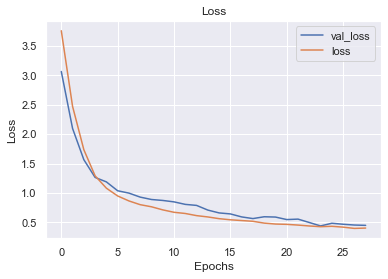

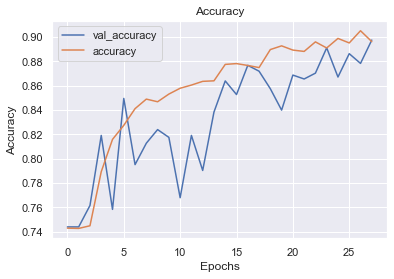

In [357]:
#plot loss and accuracy
visualize_training_results(history_5)

In [358]:
# Generate predictions on test set
predictions = model_5.predict(test_images)


In [359]:
predictions[:10]

array([[0.9607024 ],
       [0.9684379 ],
       [0.9660015 ],
       [0.93402374],
       [0.9847622 ],
       [0.9929328 ],
       [0.24988204],
       [0.37337404],
       [0.9887797 ],
       [0.6752854 ]], dtype=float32)

In [360]:
y_pred = np.round(predictions)
y_pred[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.]], dtype=float32)

In [361]:
cm_5 = confusion_matrix(test_labels, y_pred)
cm_5

array([[142,  92],
       [ 23, 367]])

In [362]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Confusion matrix, without normalization
[[142  92]
 [ 23 367]]


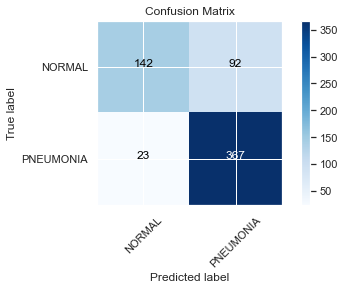

In [363]:

cm_plot_labels = ['NORMAL','PNEUMONIA']
plot_confusion_matrix(cm=cm_5, classes=cm_plot_labels, title='Confusion Matrix')

In [348]:
print(classification_report(test_labels, y_pred, target_names = ['Normal (Class 0)', 'Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.95      0.54      0.69       234
Pneumonia (Class 1)       0.78      0.98      0.87       390

           accuracy                           0.82       624
          macro avg       0.86      0.76      0.78       624
       weighted avg       0.84      0.82      0.80       624



#### Model 5 summary 

Model 5 included regularization through using L2 regularization and adding consistent dropouts of 20%. This model improved on recall scores for detecting normal lungs, a more satisfactory result at the cost of slight recall reduction on pneumonia detection. The model learned quickly at the beginning with oscillating validation results in both loss and accuracy, the model had a difficult time identifying the minimum. This model reduced overfitting compared to previous models but recall accuracy for normal lungs is still not much better than the flip of a coin.


### Model 5a - tuning learning rate and adding a callback

Reduce the amount of augmentation in the data to make it easier to identify normal lungs. Adjust the learning rate to a smaller rate and add a callback to prevent overfitting of model 5.  

In [400]:
# Augment the training and test data to account for class imbalance
train_datagen = ImageDataGenerator(rescale=1./255, 
                             rotation_range=20, 
                             width_shift_range=0.1, 
                             height_shift_range=0.1, 
                             shear_range=0.1, 
                             zoom_range=0.1, 
                             horizontal_flip=True, 
                             validation_split = 0.12)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [401]:
# Set image size for shaping
img_size = 150

# Train generator - training subset
train_generator = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(img_size, img_size), 
        batch_size = 32, 
        class_mode='binary', 
        subset = "training")

# Validation Generator - validation subset
val_generator = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(img_size, img_size),
        batch_size = 32,
        class_mode='binary', 
        subset = "validation")

# Test Generator 
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(img_size, img_size), 
        batch_size = 624,
        class_mode='binary') 

Found 4591 images belonging to 2 classes.
Found 625 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [402]:
#Instantiate a CNN model
model_5a = Sequential()

# Apply 4 Convolution with Maxpooling with regularization: Dropouts, L2, Normalization

#Layer1
model_5a.add(Conv2D(8, (3, 3), 
                   padding = 'same', strides = 1, activation = 'relu',
                   input_shape= (img_size, img_size, 3)))
model_5a.add(MaxPooling2D(pool_size=(2, 2), strides = 2))
model_5a.add(Dropout(0.1))


#Layer2

model_5a.add(Conv2D(16, (3, 3), 
                   kernel_regularizer =tf.keras.regularizers.l2(l=0.01),
                   padding = 'same', strides = 1, activation='relu'))
                    
model_5a.add(MaxPooling2D((2, 2), strides = 2))
model_5a.add(Dropout(0.1))

#Layer3
model_5a.add(Conv2D(32, (3, 3), 
                   kernel_regularizer =tf.keras.regularizers.l2(l=0.01),
                   padding = 'same', strides = 1, activation='relu'))
model_5a.add(MaxPooling2D((2, 2), strides = 2))
model_5a.add(Dropout(0.2))

#Layer4

model_5a.add(Conv2D(64, (3, 3), 
                   kernel_regularizer =tf.keras.regularizers.l2(l=0.01),
                   padding = 'same', strides = 1, activation='relu'))
model_5a.add(MaxPooling2D((2, 2), strides = 2))
model_5a.add(Dropout(0.2))

#Layer5  
model_5a.add(Conv2D(128, (3, 3),
                   kernel_regularizer =tf.keras.regularizers.l2(l=0.01),
                   padding = 'same', strides = 1, activation='relu'))
model_5a.add(MaxPooling2D((2, 2), strides = 2))
model_5a.add(Dropout(0.2))


# Flatten the model
model_5a.add(Flatten())

# Add dense layers
model_5a.add(Dense(128,  kernel_regularizer =tf.keras.regularizers.l2(l=0.01), activation = 'relu'))
model_5a.add(Dropout(0.2))

# Add the output layer for binary - normal or pneumonia

model_5a.add(Dense(1, activation = 'sigmoid'))

model_5a.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay = 1e-5),
              metrics=['accuracy'])

In [403]:
model_5a.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_193 (Conv2D)          (None, 150, 150, 8)       224       
_________________________________________________________________
max_pooling2d_181 (MaxPoolin (None, 75, 75, 8)         0         
_________________________________________________________________
dropout_139 (Dropout)        (None, 75, 75, 8)         0         
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 75, 75, 16)        1168      
_________________________________________________________________
max_pooling2d_182 (MaxPoolin (None, 37, 37, 16)        0         
_________________________________________________________________
dropout_140 (Dropout)        (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_195 (Conv2D)          (None, 37, 37, 32)      

In [320]:
from keras import callbacks

# Set early stopping for validation loss with patience at 5 epochs
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)

In [404]:
history_5a = model_5a.fit(train_generator, 
                       epochs = 96, 
                       validation_data=val_generator, 
                       callbacks = [earlystopping])

Epoch 1/96
144/144 [==============================] - 87s 605ms/step - loss: 3.6777 - accuracy: 0.7421 - val_loss: 2.9362 - val_accuracy: 0.7440
Epoch 2/96
144/144 [==============================] - 86s 594ms/step - loss: 2.3562 - accuracy: 0.7428 - val_loss: 1.9755 - val_accuracy: 0.7440
Epoch 3/96
144/144 [==============================] - 85s 593ms/step - loss: 1.6342 - accuracy: 0.7428 - val_loss: 1.4654 - val_accuracy: 0.7440
Epoch 4/96
144/144 [==============================] - 85s 591ms/step - loss: 1.2276 - accuracy: 0.7536 - val_loss: 1.1500 - val_accuracy: 0.7584
Epoch 5/96
144/144 [==============================] - 86s 595ms/step - loss: 0.9904 - accuracy: 0.7772 - val_loss: 1.0078 - val_accuracy: 0.7904
Epoch 6/96
144/144 [==============================] - 86s 599ms/step - loss: 0.8551 - accuracy: 0.8092 - val_loss: 0.9143 - val_accuracy: 0.7984
Epoch 7/96
144/144 [==============================] - 86s 597ms/step - loss: 0.7664 - accuracy: 0.8249 - val_loss: 0.8942 - val_ac

#### Model evaluation

In [415]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [416]:
results_5a_train = model_5a.evaluate(train_images, train_labels)

1/1 [==============================] - 0s 813us/step - loss: 0.2259 - accuracy: 0.9688


In [417]:
results_5a_test = model_5a.evaluate(test_images, test_labels)

20/20 [==============================] - 1s 32ms/step - loss: 0.4825 - accuracy: 0.8462


In [418]:
results_5a_val = model_5a.evaluate(val_images, val_labels)

1/1 [==============================] - 0s 828us/step - loss: 0.3278 - accuracy: 0.8750


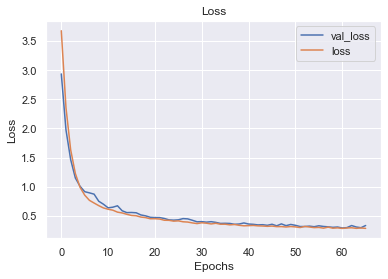

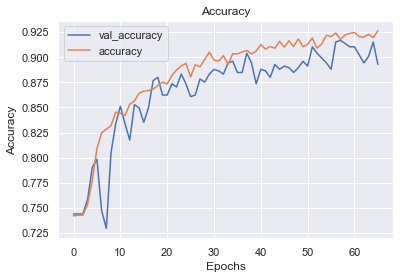

In [419]:
visualize_training_results(history_5a)

In [420]:
# Generate predictions on test set
predictions = model_5a.predict(test_images)
y_pred = np.round(predictions)
y_pred[:10]

array([[1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [421]:
cm_5a = confusion_matrix(test_labels, y_pred)
cm_5a

array([[148,  86],
       [ 10, 380]])

Confusion matrix, without normalization
[[148  86]
 [ 10 380]]


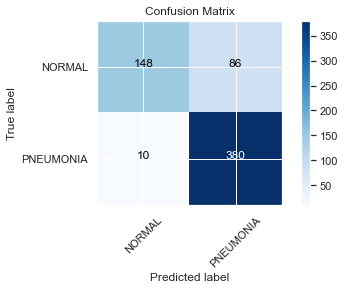

In [422]:
cm_plot_labels = ['NORMAL','PNEUMONIA']
plot_confusion_matrix(cm=cm_5a, classes=cm_plot_labels, title='Confusion Matrix')

In [423]:
print(classification_report(test_labels, y_pred, target_names = ['Normal (Class 0)', 'Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.94      0.63      0.76       234
Pneumonia (Class 1)       0.82      0.97      0.89       390

           accuracy                           0.85       624
          macro avg       0.88      0.80      0.82       624
       weighted avg       0.86      0.85      0.84       624



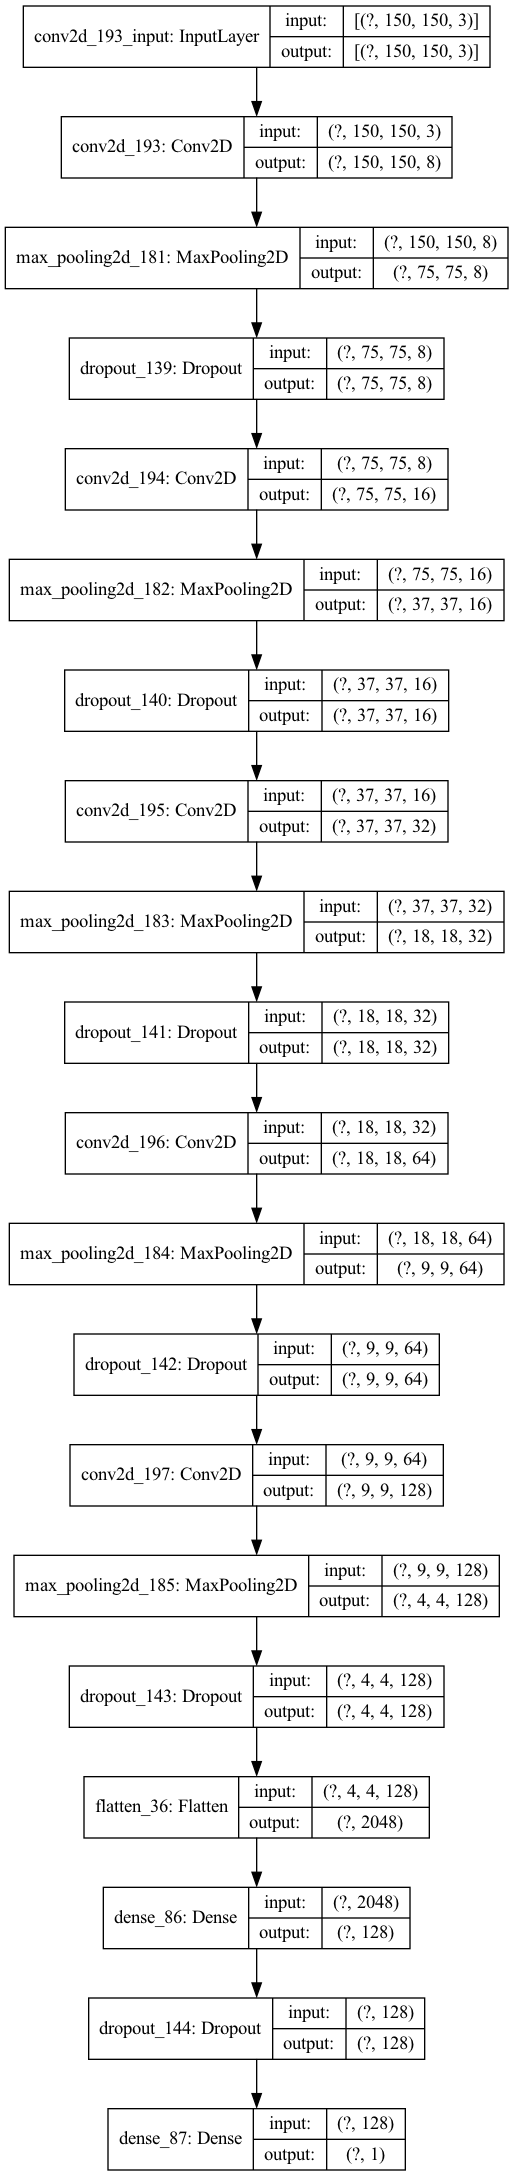

In [424]:
# Visualize the model architecture flow
import graphviz
import pydot
from keras.utils.vis_utils import plot_model
plot_model(model_5a, to_file = 'model_5a_architecture.png', show_shapes = True, show_layer_names = True)

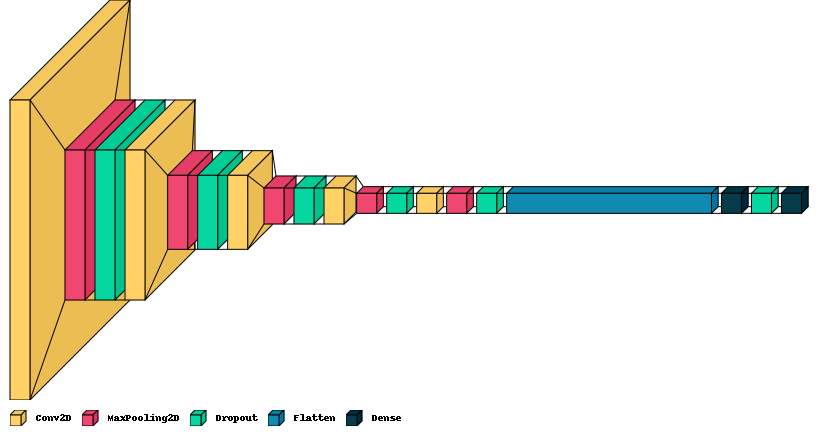

In [425]:
# Visualize the model build with Keras
import visualkeras
from PIL import ImageFont
#font = ImageFont.truetype("arial.ttf")

visualkeras.layered_view(model_5a, legend=True, scale_xy = 2, to_file = 'visual_model_5a.png') 


#### model 5a summary

This model kept the same layers and paremeters as model 5 but included reduced data augmentation and an adjusted learning rate of 0.0001 and a callback to end the training if no validation loss was observed after 5 epochs. Recall accuracy score improved on pneumonia identification (97%). Recall accuracy for normal lungs also improved to 63%, better but not as much as hoped. For now this is our best model for our business case. 

In [429]:
#save model 5a as final model
final_model = model_5a
# save model and architecture to single file
final_model.save("final_model.h5")
print("Saved model to disk")

Saved model to disk


## Final Summary

It is possible to keep tuning and adding or subtracting layers. After 7 model iterations, including the baseline model, model 5a delivers the most acceptable results based upon recall accuracy scores and narrowness in accuracy scores between the training dataset and the test dataset. While overfitting exists, model 5a offers the most acceptable results between training and testing data compared to previous models.

In [430]:
#Print results for Model 5 train and test
print("Model 5 Results from Training Data, loss and accuracy:", results_5a_train)
print()
print("Model 5 Results from Test Data, loss and accuracy:", results_5a_test)

Model 5 Results from Training Data, loss and accuracy: [0.2259228229522705, 0.96875]

Model 5 Results from Test Data, loss and accuracy: [0.48247581720352173, 0.8461538553237915]


Model 5a also delivered more promising results on test data when it comes to accurately predicting true cases of pneumonia and true cases of normal lungs while minimizing the numbers of false negative cases of pneumonia. Considering we are working with pediatric patients who are susceptible to harm, even death, from pneumonia, it is critical the model minimizes false negatives. 

While the number of 86 false positives is higher than 10 false negatives in the test set, this is a more acceptable outcome when it comes to patient care because we trying to catch as many cases of pneumonia as possible. While potentially a scary scenario for the patient and their family who receive a false positive diagnosis, ultimately they do not have pneumonia. 

The classification report details the model's precision and accuracy per model class:

                            precision    recall  f1-score   support

         Normal (Class 0)       0.94      0.63      0.76       234
      Pneumonia (Class 1)       0.82      0.97      0.89       390

                 accuracy                           0.85       624



Confusion matrix, without normalization
[[148  86]
 [ 10 380]]


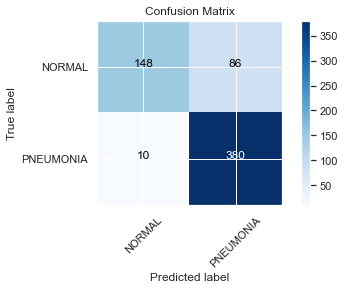

In [431]:
plot_confusion_matrix(cm=cm_5a, classes=cm_plot_labels, title='Confusion Matrix')
plt.savefig('model_5a_cm.png')

## Recommendations

### 1. 
The final model can be prototyped in the clinic for pediatric patients with a 97% pneumonia recall accuracy rate. Wait times for radiology results are often the cause of delay in diagnosis times. Use of the model can reduce diagnosis turnaround times to reduce costs and improve patient outcomes. The model could initially be implemented in a controlled setting with both clinican and radiology experts diagnosing a group of patients along with the model. 

### 2. 
Neural network models are often useful for other problems. This model can be trained on images for other groups of patients, particularly the elderly who also suffer poorer outcomes from pneumonia. Gathering quality controlled images of lungs of elderly patients to train a new model for deployment would be beneficial for rapid assessment and diagnosis, improved patient outcomes and increased clinical efficiency. 

#### Model Limitations
There are two important things to note about the model. The first is that the model identifies whether a patient has pneumonia or not with a higher rate of false positives compared to false negatives, a better outcome for patients with pneumonia at the cost of some false positives. The second is that the model does not discriminate among viral, bacterial, or fungal origins. It also does not identify whether pneumonia is community or hospital acquired. Clinicians and radiologists will still need to be involved in key stages after diagnosis of pneumonia to determine the course of treatment and care.